<h2>NLP Portfolio Project: Text Message Analysis</h2>
<hr>
Welcome to my Natural Language Processing project! 
This project's dataset is provided by Codecademy as part of completing 'Apply Natural Language Processing with Python' Skill Path. In this project, I'm tasked with applying NLP techniques and libraries to <b>clean_nus_sms.csv</b>, a text message dataset. With this type of dataset, it's common to do a sentiment analysis or spam prediction. The solution to this project showcases a sentiment analysis, so I will do spam prediction.

Here are the steps done  in this project to reach the end goal:
1. [Importing Libraries](#import_library)
2. [Data Observation](#data_observation)
3. [Exploratory Data Analysis](#eda)
4. [Data Preprocessing](#preprocessing)
5. [Most Common Unigram, Bigram, and Trigram](#common_ngram)
6. [Message Spam Prediction Model with Naive Bayes Classifier](#spam_prediction)
7. [Conclusion](#conclusion)

<a id='import_library'></a>
<h3>Import Libraries</h3>
First, let's import some libraries needed for the project. Some libraries are used, some don't. I was experimenting and things end up a little cluttered.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from nltk.util import ngrams
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

Here I set up the language of the stopwords

In [2]:
eng_stop = stopwords.words('english')

<a id='data_observation'></a>
<h3>Data Observation</h3>
Next, I load the <b>clean_nus_sms.csv</b> dataset and assign it to <code>msg</code>.

In [3]:
msg = pd.read_csv('clean_nus_sms.csv')
msg

,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4
...,...,...,...,...,...,...
48593,55828,45712,Come to me AFTER NOON,21,Serbia,2015/3
48594,55830,45714,I LOVE YOU TOO,14,Serbia,2015/3
48595,55831,45715,C-YA,4,Serbia,2015/3
48596,55833,45717,BE MY GUEST,11,Serbia,2015/3


By calling <code>msg.info()</code>, I get to see the dataset's information. The datset has 48597 rows x 6 columns with column names specified below.

In [4]:
msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


Then I check if the dataset has missing values. It seems the Message column has 3 missing values.

In [5]:
msg.isna().sum()

Unnamed: 0    0
id            0
Message       3
length        0
country       0
Date          0
dtype: int64

In [6]:
nanval = msg[msg.Message.isna()]
nanval

,Unnamed: 0,id,Message,length,country,Date
3461,3629,13749,NaN,4,SG,2003/4
4593,4807,14927,NaN,3,SG,2003/4
46656,53567,43451,NaN,4,USA,2014/9


Since it's a text message dataset, I can't really fill it in, so I decide to drop the row.

In [7]:
msg = msg.dropna()
msg.isna().sum()

Unnamed: 0    0
id            0
Message       0
length        0
country       0
Date          0
dtype: int64

By dropping 3 rows, the dataset now has 48595 rows.

In [8]:
msg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48595 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48595 non-null  int64 
 1   id          48595 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48595 non-null  object
 4   country     48595 non-null  object
 5   Date        48595 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.6+ MB


I also drop the 'Unnamed: 0' column since it doesn't hold any meaning.

In [9]:
msg = msg.drop(columns=['Unnamed: 0'])
msg

,id,Message,length,country,Date
0,10120,Bugis oso near wat...,21,SG,2003/4
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,10124,Meet after lunch la...,22,SG,2003/4
...,...,...,...,...,...
48593,45712,Come to me AFTER NOON,21,Serbia,2015/3
48594,45714,I LOVE YOU TOO,14,Serbia,2015/3
48595,45715,C-YA,4,Serbia,2015/3
48596,45717,BE MY GUEST,11,Serbia,2015/3


<a id='eda'></a>
<h3>Exploratory Data Analysis</h3>
Next, I perform some exploratory data analysis to get to know more about the dataset.

<code>msg.country.value_counts()</code> looks over the dataset's 'country' column to find the unique values and its total occurences in the columm. By doing this, I can find the total messages from each country.

In [10]:
msg.country.value_counts()

Singapore              22013
SG                      9804
India                   6901
United States           3749
USA                     1931
Sri Lanka               1017
Malaysia                 766
Pakistan                 751
unknown                  602
Canada                   198
Bangladesh               126
China                    107
india                    105
INDIA                     79
Philippines               67
Indonesia                 48
Nepal                     39
srilanka                  30
United Kingdom            30
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Turkey                    10
Trinidad and Tobago       10
Lebanon                   10
Slovenia                  10
Nigeria                   10
New Zealand               10
Macedonia                 10
UK                        10
Morocco                    9
Romania                    9
Australia     

Some values are either a duplicate, a misstype or an abbreviation of the other value. So, I rename them.

In [11]:
msg = msg.replace({'SG':'Singapore',\
                          'USA':'United States',\
                          'MY': 'Malaysia',\
                          'jamaica': 'Jamaica',\
                          'srilanka': 'Sri Lanka',\
                          'INDIA': 'India',\
                          'india':'India',\
                          'unknown':'Unknown',\
                          'BARBADOS':'Barbados',\
                          'UK':'United Kingdom'})

In [12]:
msg.country.value_counts()

Singapore              31817
India                   7085
United States           5680
Sri Lanka               1047
Malaysia                 767
Pakistan                 751
Unknown                  602
Canada                   198
Bangladesh               126
China                    107
Philippines               67
Indonesia                 48
United Kingdom            40
Nepal                     39
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Trinidad and Tobago       10
Lebanon                   10
Turkey                    10
Nigeria                   10
New Zealand               10
Slovenia                  10
Macedonia                 10
Morocco                    9
Australia                  9
Romania                    9
Jamaica                    8
Barbados                   8
Spain                      5
France                     5
Name: country, dtype: int64

Next, I make a new DataFrame so I can visualize it.

In [13]:
msg_bycountry = pd.DataFrame(msg.country.value_counts())
msg_bycountry

,country
Singapore,31817
India,7085
United States,5680
Sri Lanka,1047
Malaysia,767
Pakistan,751
Unknown,602
Canada,198
Bangladesh,126
China,107


The visualization below details the total messages that made up the dataset. Singapore has the most messages reaching 31814 messages followed by India with 7085 messages and United States with 5679 messages.

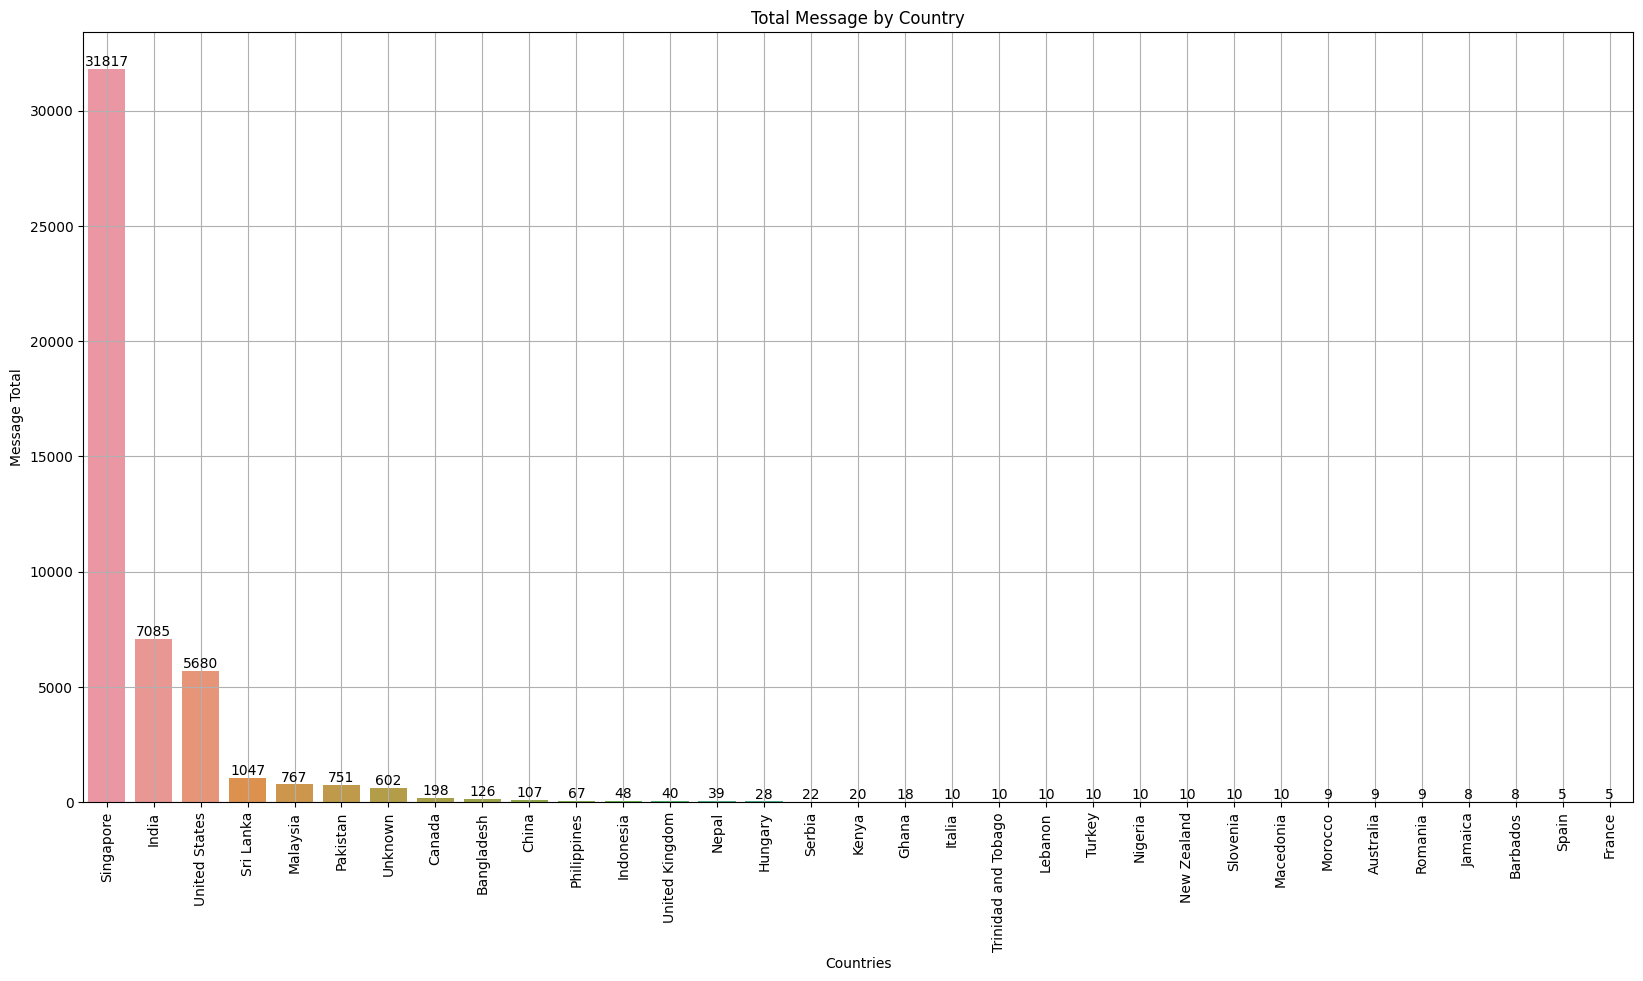

In [14]:
plt.figure(figsize=(20,10))
sum_msg_country = sns.barplot(x=msg_bycountry.index, y=msg_bycountry.country)
sum_msg_country.bar_label(sum_msg_country.containers[0])
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.ylabel('Message Total')
plt.title('Total Message by Country')
plt.grid()
plt.show()

Next, I want to see from what year the messages come from.

In [15]:
msg.Date.unique()

array(['2003/4', '2010/11', '2010/12', '2011/1', '2011/2', '2011/3',
       '2011/4', '2011/5', '2011/6', '2011/8', '2011/9', '2011/11',
       '2011/12', '2012/2', '2012/3', '2012/4', '2012/5', '2012/6',
       '2012/7', '2012/8', '2012/10', '2013/5', '2014/9', '2014/11',
       '2014/12', '2015/2', '2015/3'], dtype=object)

I decided to make another column called 'year' to store the message's year.

In [16]:
msg['year'] = msg.Date.str[:4]
msg

,id,Message,length,country,Date,year
0,10120,Bugis oso near wat...,21,Singapore,2003/4,2003
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,2003
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,2003
3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,2003
4,10124,Meet after lunch la...,22,Singapore,2003/4,2003
...,...,...,...,...,...,...
48593,45712,Come to me AFTER NOON,21,Serbia,2015/3,2015
48594,45714,I LOVE YOU TOO,14,Serbia,2015/3,2015
48595,45715,C-YA,4,Serbia,2015/3,2015
48596,45717,BE MY GUEST,11,Serbia,2015/3,2015


Then I make a new DataFrame to store the total message by each year.

In [17]:
msg_byyear = pd.DataFrame(msg.year.value_counts())
msg_byyear

,year
2011,33661
2003,9805
2014,2607
2010,1479
2012,671
2015,317
2013,55


The visualization below depicts the total message from each year. Most message come from 2011 with a total of 33658 followed by 2003 with 9804 messages and 2014 with 2607 messages.

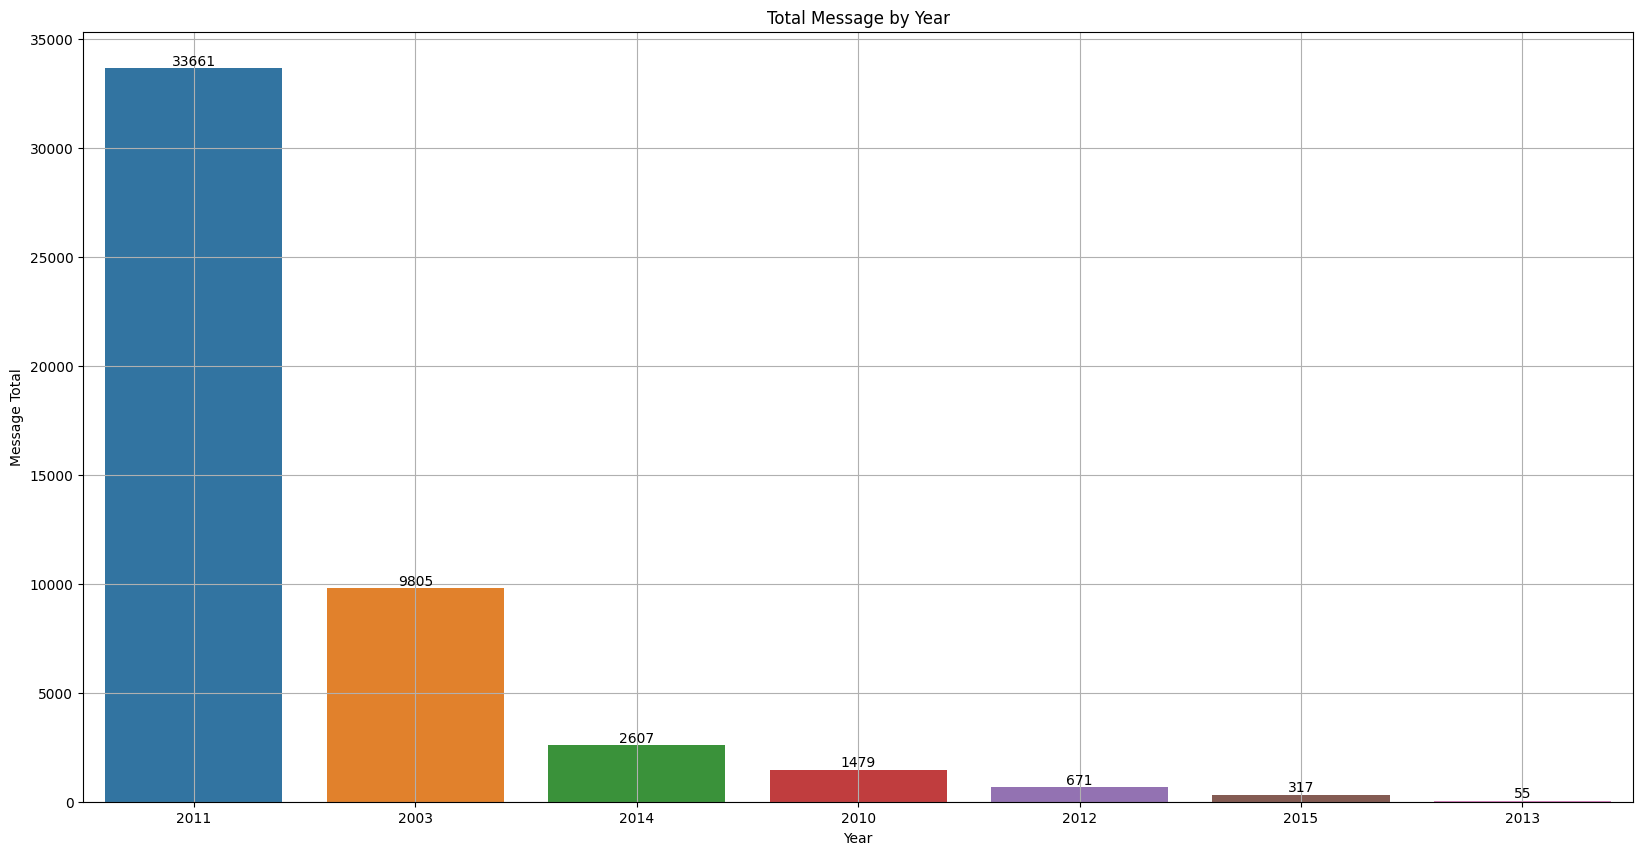

In [18]:
plt.figure(figsize=(20,10))
sum_msg_year = sns.barplot(x=msg_byyear.index, y=msg_byyear.year)
sum_msg_year.bar_label(sum_msg_year.containers[0])
plt.xlabel('Year')
plt.ylabel('Message Total')
plt.title('Total Message by Year')
plt.grid()
plt.show()

<a id='preprocessing'></a>
<h3>Data Preprocessing</h3>
Now I preprocess the data to find the most common unigram, bigram, and trigram in the dataset, also in messages from Singapore, India, and United States.

The code below preprocesses the dataset's messages by (in order) converting the text into lowercase, erasing the punctuation, urls, html tags, duplicate whitespaces, and stopwords.

In [19]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)
    html_pattern = re.compile('<.*?>')
    text = html_pattern.sub(r'', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = " ".join([word for word in str(text).split() if word not in eng_stop])
    return text

In [20]:
msg['msg_process'] = msg.Message.apply(lambda text: preprocess(text))
msg

,id,Message,length,country,Date,year,msg_process
0,10120,Bugis oso near wat...,21,Singapore,2003/4,2003,bugis oso near wat
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,2003,go jurong point crazy available bugis n great ...
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,2003,dunno lets go learn pilates
3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,2003,den weekdays got special price haiz cant eat l...
4,10124,Meet after lunch la...,22,Singapore,2003/4,2003,meet lunch la
...,...,...,...,...,...,...,...
48593,45712,Come to me AFTER NOON,21,Serbia,2015/3,2015,come noon
48594,45714,I LOVE YOU TOO,14,Serbia,2015/3,2015,love
48595,45715,C-YA,4,Serbia,2015/3,2015,c ya
48596,45717,BE MY GUEST,11,Serbia,2015/3,2015,guest


Then, I tokenize the texts.

In [21]:
msg['msg_token'] = msg.msg_process.apply(lambda text: word_tokenize(text))
msg

,id,Message,length,country,Date,year,msg_process,msg_token
0,10120,Bugis oso near wat...,21,Singapore,2003/4,2003,bugis oso near wat,"[bugis, oso, near, wat]"
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,2003,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,2003,dunno lets go learn pilates,"[dunno, lets, go, learn, pilates]"
3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,2003,den weekdays got special price haiz cant eat l...,"[den, weekdays, got, special, price, haiz, can..."
4,10124,Meet after lunch la...,22,Singapore,2003/4,2003,meet lunch la,"[meet, lunch, la]"
...,...,...,...,...,...,...,...,...
48593,45712,Come to me AFTER NOON,21,Serbia,2015/3,2015,come noon,"[come, noon]"
48594,45714,I LOVE YOU TOO,14,Serbia,2015/3,2015,love,[love]
48595,45715,C-YA,4,Serbia,2015/3,2015,c ya,"[c, ya]"
48596,45717,BE MY GUEST,11,Serbia,2015/3,2015,guest,[guest]


<a id='common_ngram'></a>
<h3>Most Common Unigram, Bigram, and Trigram</h3>

Next, I will get the top 10 most common unigram, bigram and trigram from all messages.

In [22]:
all_msg = []
for line in msg.msg_token:
    for word in line:
        all_msg.append(word)
msg_count = Counter(all_msg)
msg_count.most_common(10)

[('u', 10282),
 ('haha', 6967),
 ('go', 3349),
 ('lol', 3261),
 ('got', 2627),
 ('ok', 2440),
 ('time', 2034),
 ('hahaha', 1822),
 ('okay', 1740),
 ('ur', 1670)]

In [23]:
msg_bigram = ngrams(all_msg, 2)
count_bigram = Counter(msg_bigram)
count_bigram.most_common(10)

[(('wan', 'na'), 649),
 (('r', 'u'), 386),
 (('haha', 'okay'), 373),
 (('u', 'wan'), 334),
 (('can', 'not'), 310),
 (('haha', 'yeah'), 287),
 (('gon', 'na'), 261),
 (('wat', 'time'), 237),
 (('u', 'r'), 233),
 (('let', 'know'), 227)]

In [24]:
msg_trigram = ngrams(all_msg, 3)
count_trigram = Counter(msg_trigram)
count_trigram.most_common(10)

[(('wan', 'na', 'go'), 124),
 (('u', 'wan', 'na'), 105),
 (('may', 'bles', 'u'), 96),
 (('happy', 'new', 'year'), 78),
 (('wat', 'time', 'u'), 74),
 (('┾', '┾', '┾'), 63),
 (('wan', 'na', 'meet'), 60),
 (('sob', 'sob', 'sob'), 57),
 (('reach', 'home', 'le'), 42),
 (('via', 'way2sms', 'com'), 37)]

Here is Singapore's top 10 most common unigram, bigram, and trigram.

In [25]:
sg, sg_token = [], []
sg = msg[msg.country == 'Singapore']
for line in sg.msg_token:
    for word in line:
        sg_token.append(word)
sg_count = Counter(sg_token)
sg_count.most_common(10)

[('u', 7927),
 ('haha', 6648),
 ('go', 2904),
 ('lol', 2818),
 ('got', 2229),
 ('ok', 1815),
 ('hahaha', 1752),
 ('okay', 1625),
 ('time', 1542),
 ('le', 1458)]

In [26]:
sg_bigram = ngrams(sg_token, 2)
sg_count2 = Counter(sg_bigram)
sg_count2.most_common(10)

[(('wan', 'na'), 567),
 (('haha', 'okay'), 367),
 (('u', 'wan'), 320),
 (('can', 'not'), 282),
 (('haha', 'yeah'), 273),
 (('wat', 'time'), 229),
 (('r', 'u'), 202),
 (('lol', 'haha'), 192),
 (('haha', 'haha'), 180),
 (('u', 'got'), 179)]

In [27]:
sg_trigram = ngrams(sg_token, 3)
sg_count3 = Counter(sg_trigram)
sg_count3.most_common(10)

[(('wan', 'na', 'go'), 115),
 (('u', 'wan', 'na'), 95),
 (('wat', 'time', 'u'), 73),
 (('sob', 'sob', 'sob'), 57),
 (('wan', 'na', 'meet'), 55),
 (('reach', 'home', 'le'), 41),
 (('happy', 'new', 'year'), 35),
 (('u', 'wan', '2'), 33),
 (('wan', 'na', 'play'), 28),
 (('sorry', 'late', 'reply'), 28)]

Here is India's top 10 most common unigram, bigram, and trigram.

In [28]:
ind, ind_token = [], []
ind = msg[msg.country == 'India']
for line in ind.msg_token:
    for word in line:
        ind_token.append(word)
ind_count = Counter(ind_token)
ind_count.most_common(10)

[('u', 1139),
 ('k', 402),
 ('2', 338),
 ('ur', 320),
 ('ok', 301),
 ('call', 273),
 ('come', 260),
 ('hey', 247),
 ('r', 244),
 ('n', 237)]

In [29]:
ind_bigram = ngrams(ind_token, 2)
ind_count2 = Counter(ind_bigram)
ind_count2.most_common(10)

[(('k', 'k'), 93),
 (('u', 'r'), 84),
 (('r', 'u'), 75),
 (('┾', '┾'), 67),
 (('take', 'care'), 51),
 (('good', 'morning'), 40),
 (('via', 'way2sms'), 37),
 (('way2sms', 'com'), 37),
 (('sent', 'via'), 31),
 (('let', 'know'), 31)]

In [30]:
ind_trigram = ngrams(ind_token, 3)
ind_count3 = Counter(ind_trigram)
ind_count3.most_common(10)

[(('┾', '┾', '┾'), 63),
 (('via', 'way2sms', 'com'), 37),
 (('sent', 'via', 'way2sms'), 29),
 (('begin', 'vcard', 'version'), 18),
 (('vcard', 'version', 'decimal'), 18),
 (('version', 'decimal', 'n'), 18),
 (('x', 'class', 'private'), 17),
 (('class', 'private', 'end'), 17),
 (('private', 'end', 'vcard'), 17),
 (('oh', 'k', 'k'), 11)]

Here is United States's top 10 most common unigram, bigram, and trigram.

In [31]:
usa, usa_token = [], []
usa = msg[msg.country == 'United States']
for line in usa.msg_token:
    for word in line:
        usa_token.append(word)
usa_count = Counter(usa_token)
usa_count.most_common(10)

[('get', 357),
 ('know', 315),
 ('lol', 278),
 ('u', 274),
 ('thanks', 256),
 ('like', 252),
 ('yeah', 207),
 ('hi', 201),
 ('want', 191),
 ('love', 180)]

In [32]:
usa_bigram = ngrams(usa_token, 2)
usa_count2 = Counter(usa_bigram)
usa_count2.most_common(10)

[(('gon', 'na'), 99),
 (('let', 'know'), 69),
 (('hi', 'ricky'), 57),
 (('wan', 'na'), 46),
 (('thanks', 'hi'), 45),
 (('ok', 'thanks'), 19),
 (('last', 'night'), 18),
 (('thanks', 'ok'), 17),
 (('u', 'get'), 17),
 (('caw', 'caw'), 17)]

In [33]:
usa_trigram = ngrams(usa_token, 3)
usa_count3 = Counter(usa_trigram)
usa_count3.most_common(10)

[(('thanks', 'hi', 'ricky'), 17),
 (('gon', 'na', 'get'), 10),
 (('lem', 'me', 'know'), 10),
 (('gon', 'na', 'go'), 9),
 (('let', 'us', 'know'), 9),
 (('happy', 'new', 'year'), 8),
 (('hi', 'ing', 'cheong'), 8),
 (('hi', 'yeng', 'chin'), 8),
 (('please', 'let', 'know'), 7),
 (('email', 'address', 'email'), 7)]

<a id='spam_prediction'></a>
<h3>Message Spam Prediction Model with Naive Bayes Classifier</h3>

Next, I will make a spam prediction model using Naive Bayes and a dataset from Kaggle named 'SMS Spam Collection Dataset' (https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset). After making the model, I will apply it to <b>clean_nus_sms.csv</b> and do an analysis of it.

This dataset labels non-spam message with 'ham' and spam message with 'spam'.

In [34]:
spam = pd.read_csv('spam.csv', sep=',', encoding = "ISO-8859-1")
spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


Check dataset composition.

In [35]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Check for missing values.

In [36]:
spam.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Dropping unused columns.

In [37]:
spam = spam.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
spam

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Dataset preprocessing.

In [38]:
spam['spam_process'] = spam['v2'].apply(lambda text: preprocess(text))
spam

,v1,v2,spam_process
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u å£750 pound prize...
5568,ham,Will Ì_ b going to esplanade fr home?,ì b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...


In [39]:
spam['spam_token'] = spam['spam_process'].apply(lambda text: word_tokenize(text))
spam

,v1,v2,spam_process,spam_token
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u å£750 pound prize...,"[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,ham,Will Ì_ b going to esplanade fr home?,ì b going esplanade fr home,"[ì, b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggestions,"[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...,"[guy, bitching, acted, like, interested, buyin..."


Apparently <code>TfidfVectorizer()</code> comes with its own preprocessing tools, so the things I did above is pointless oops.

I'm using <code>TfidfVectorizer()</code> because it works better in a big corpus with a lot of unique values than <code>CountVectorizer()</code>.

In [40]:
tfidf_vec = TfidfVectorizer()
spam_tfidf = tfidf_vec.fit_transform(spam.v2)
spam_df = pd.DataFrame(spam_tfidf.T.toarray(), index=tfidf_vec.get_feature_names_out())
spam_df

,0,1,2,3,4,5,6,7,8,9,...,5562,5563,5564,5565,5566,5567,5568,5569,5570,5571
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000pes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
008704050406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ûªve,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ûï,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ûïharry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ûò,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Splitting dataset and label into training set and test set.

In [41]:
spam_train, spam_test, label_train, label_test = train_test_split(spam_tfidf, spam['v1'], test_size=0.2, random_state=7)

In [42]:
print("train dataset features size : ",spam_train.shape)
print("train dataset label size", label_train.shape)
print("test dataset features size", spam_test.shape)
print("test dataset lable size", label_test.shape)

train dataset features size :  (4457, 8672)
train dataset label size (4457,)
test dataset features size (1115, 8672)
test dataset lable size (1115,)


Training the Naive Bayes with the training sets.

In [43]:
detect = MultinomialNB()
spam_detect = detect.fit(spam_train, label_train)

Testing the model with the train set.

In [44]:
predict_train = spam_detect.predict(spam_train)

In [45]:
print(metrics.classification_report(label_train, predict_train))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      3855
        spam       1.00      0.77      0.87       602

    accuracy                           0.97      4457
   macro avg       0.98      0.89      0.93      4457
weighted avg       0.97      0.97      0.97      4457



Testing the model with the test set.

In [46]:
predict_test = spam_detect.predict(spam_test)

In [47]:
print(metrics.classification_report(label_test, predict_test))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       970
        spam       1.00      0.74      0.85       145

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.97      0.96      1115



Using the model to predict <b>clean_nus_sms.csv</b> label.

In [48]:
sample_predict = tfidf_vec.transform(msg.Message)

In [49]:
predict_msg = spam_detect.predict(sample_predict)
predict_msg

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

Merging the label with the dataset.

In [50]:
msg['label'] = predict_msg
msg

,id,Message,length,country,Date,year,msg_process,msg_token,label
0,10120,Bugis oso near wat...,21,Singapore,2003/4,2003,bugis oso near wat,"[bugis, oso, near, wat]",ham
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,2003,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...",ham
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,2003,dunno lets go learn pilates,"[dunno, lets, go, learn, pilates]",ham
3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,2003,den weekdays got special price haiz cant eat l...,"[den, weekdays, got, special, price, haiz, can...",ham
4,10124,Meet after lunch la...,22,Singapore,2003/4,2003,meet lunch la,"[meet, lunch, la]",ham
...,...,...,...,...,...,...,...,...,...
48593,45712,Come to me AFTER NOON,21,Serbia,2015/3,2015,come noon,"[come, noon]",ham
48594,45714,I LOVE YOU TOO,14,Serbia,2015/3,2015,love,[love],ham
48595,45715,C-YA,4,Serbia,2015/3,2015,c ya,"[c, ya]",ham
48596,45717,BE MY GUEST,11,Serbia,2015/3,2015,guest,[guest],ham


According to the model, the dataset only has 36 spam messages.

In [51]:
msg[msg['label'] == 'spam']

,id,Message,length,country,Date,year,msg_process,msg_token,label
5523,15894,Mi 18 f chi u,13,Singapore,2003/4,2003,mi 18 f chi u,"[mi, 18, f, chi, u]",spam
7613,18015,"1st wk sports unlimited extreme camp-eca- 2nd,...",56,Singapore,2003/4,2003,1st wk sports unlimited extreme camp eca 2nd h...,"[1st, wk, sports, unlimited, extreme, camp, ec...",spam
8571,18985,05:45:00 PM,17,Singapore,2003/4,2003,05 45 00 pm,"[05, 45, 00, pm]",spam
8630,19046,06:00:00 PM,4,Singapore,2003/4,2003,06 00 00 pm,"[06, 00, 00, pm]",spam
9178,19598,03:00:00 PM,5,Singapore,2003/4,2003,03 00 00 pm,"[03, 00, 00, pm]",spam
9798,20228,race 4-7 Ashgrove $100,22,Singapore,2003/4,2003,race 4 7 ashgrove 100,"[race, 4, 7, ashgrove, 100]",spam
11470,2019,Downld frm www.fiveyearpk.com,29,Pakistan,2011/1,2011,downld frm www fiveyearpk com,"[downld, frm, www, fiveyearpk, com]",spam
11635,2187,Apply eox <#>,13,India,2011/1,2011,apply eox,"[apply, eox]",spam
11639,2191,APPLY RBZ <#>,13,India,2011/1,2011,apply rbz,"[apply, rbz]",spam
12329,2959,Win.,4,India,2011/1,2011,win,[win],spam


In [52]:
msg_label_count = pd.DataFrame(msg.label.value_counts())
msg_label_count

,label
ham,48559
spam,36


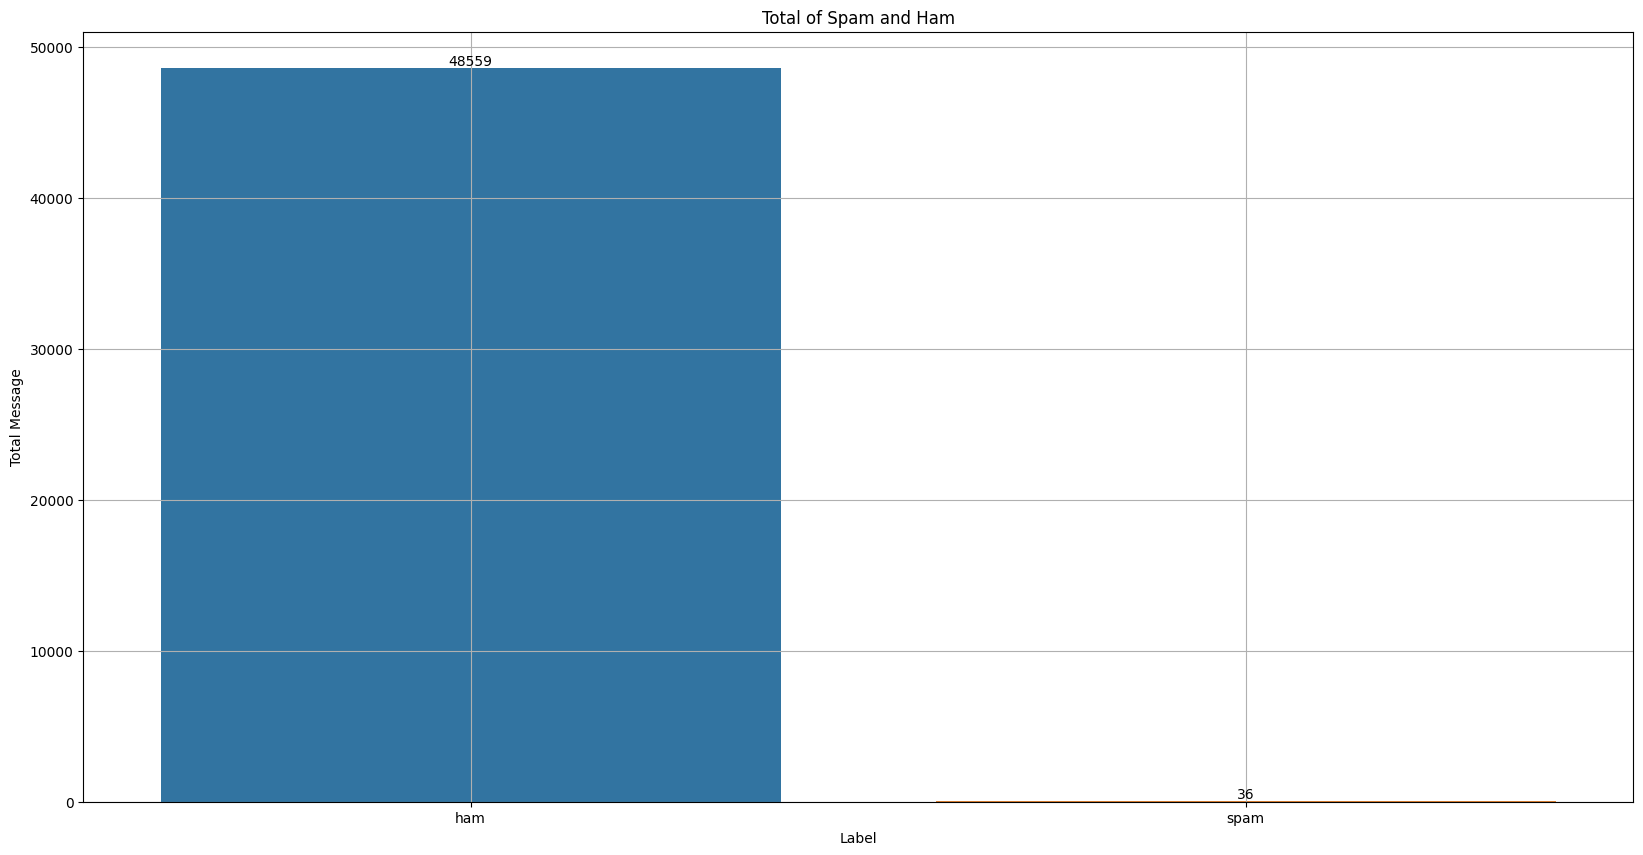

In [53]:
plt.figure(figsize=(20,10))
msg_label = sns.barplot(x=msg_label_count.index, y=msg_label_count.label)
msg_label.bar_label(msg_label.containers[0])
plt.title('Total of Spam and Ham')
plt.xlabel('Label')
plt.ylabel('Total Message')
plt.grid()
plt.show()

Here are the countries with the spam messages. Singapore has 14 spam messages followed by India with 11 spam messages and United States with 5 spam messages.

In [54]:
msg_spam_country = msg[msg['label'] == 'spam']
msg_spam_country = pd.DataFrame(msg_spam_country.country.value_counts())
msg_spam_country

,country
Singapore,14
India,11
United States,5
Pakistan,3
Unknown,2
Malaysia,1


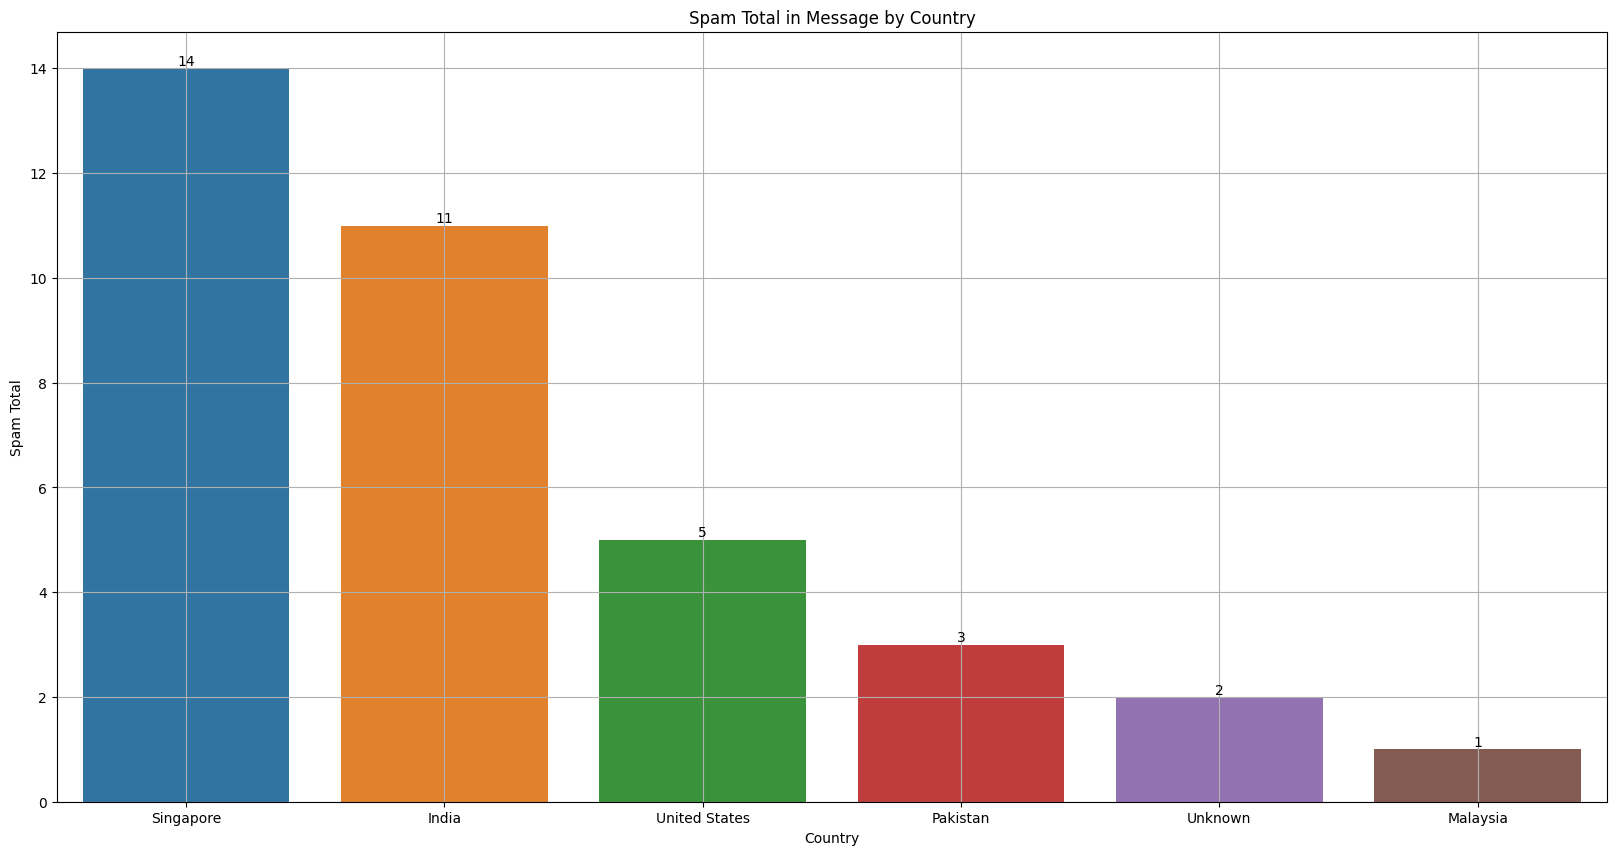

In [55]:
plt.figure(figsize=(20,10))
msg_country_spam = sns.barplot(x=msg_spam_country.index, y =msg_spam_country.country)
msg_country_spam.bar_label(msg_country_spam.containers[0])
plt.xlabel('Country')
plt.ylabel('Spam Total')
plt.title('Spam Total in Message by Country')
plt.grid()
plt.show()

<a id='conclusion'></a>
<h2>Conclusion</h2>
<hr>
This concludes the NLP project. Here are the discoveries made after doing the project:

1. Singapore has the most messages reaching 31814 messages followed by India with 7085 messages and United States with 5679 messages.
2. Most messages come from 2011 with a total of 33658 followed by 2003 with 9804 messages and 2014 with 2607 messages.
3. ('┾', '┾', '┾') Appears to be India's most common trigram.
4. The spam prediction model reached 0.97 accuracy.
5. According to the spam prediction model, the dataset has only 36 spam messages.
6. Singapore has 14 spam messages followed by India with 11 spam messages and United States with 5 spam messages. 

Following this, I hope I'll be able to perform more machine learning and deep learning techniques. Thank you for your attention!